# Classification Evaluation

In [6]:
import pandas as pd

In [28]:
import sklearn

import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [29]:
sklearn.set_config(display="diagram")

# 1. Import Data

In [30]:
df = pd.read_csv("datasets/titanic.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
5,0,3,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
len(df)

891

In [32]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)

# 2. Preprocessing

In [33]:
# Find and Impute Deck

import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [34]:
# Impute Age

data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = train_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [35]:
#Impute NAs
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [36]:
# Label-Encode Titles
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [37]:
# Label-Encode Titles
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [38]:
# Remove ticket column
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [39]:
# Label-Encode Ports
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [40]:
# Group Age
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [41]:
# Group Fares
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# 3. Model Training

In [42]:
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test  = test_df.drop("Survived", axis=1).copy()
y_test = test_df["Survived"]

0.7653631284916201


<AxesSubplot:>

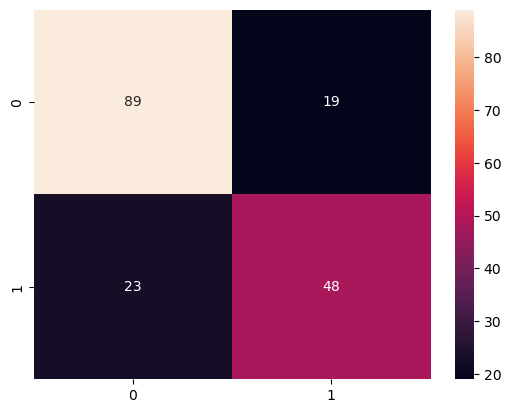

In [49]:
#1  Let's fit a basic model
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred_test = clf.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
print(accuracy_score(y_true=y_test, y_pred=y_pred_test))
import seaborn as sns
sns.heatmap(cm, annot=True) 

0.7877094972067039


<AxesSubplot:>

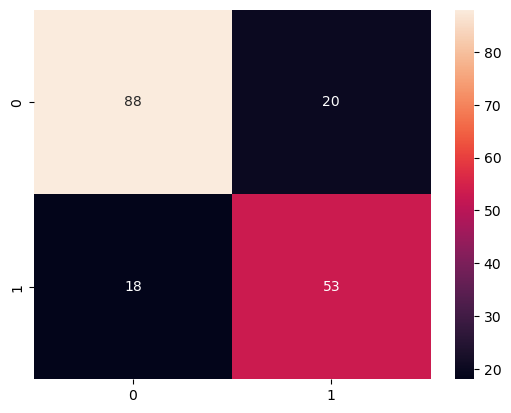

In [50]:
#2  Let's fit a basic model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, random_state = 42, bootstrap=True).fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
print(accuracy_score(y_true=y_test, y_pred=y_pred_test))
import seaborn as sns
sns.heatmap(cm, annot=True) 

0.7374301675977654


C:\Users\nx027313\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<AxesSubplot:>

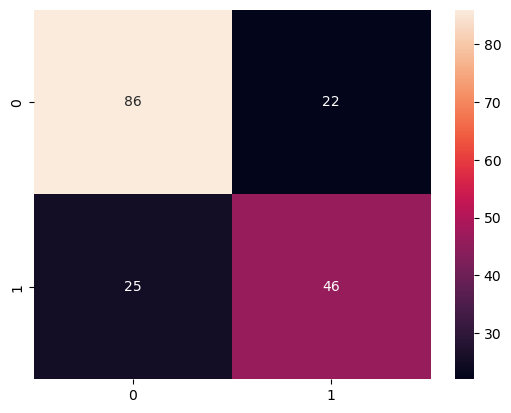

In [51]:
#3
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
print(accuracy_score(y_true=y_test, y_pred=y_pred_test))
import seaborn as sns
sns.heatmap(cm, annot=True) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 9)                 90        
                                                                 
 activation_2 (Activation)   (None, 9)                 0         
                                                                 
 dense_3 (Dense)             (None, 9)                 90        
                                                                 
 activation_3 (Activation)   (None, 9)                 0         
                                                                 
 dense_4 (Dense)             (None, 2)                 20        
                                                                 
 activation_4 (Activation)   (None, 2)                 0         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable 

Epoch 86/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1333
Epoch 87/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1336
Epoch 88/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1331
Epoch 89/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1342
Epoch 90/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1328
Epoch 91/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1327
Epoch 92/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1323
Epoch 93/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1325
Epoch 94/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1321
Epoch 95/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1318
Epoch 96/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1319
Epoch 97/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1315
Epoch 98/1000
23

23/23 [==============================] - 0s 1ms/step - loss: 0.1211
Epoch 185/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1211
Epoch 186/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1218
Epoch 187/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1207
Epoch 188/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1203
Epoch 189/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1202
Epoch 190/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1202
Epoch 191/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1205
Epoch 192/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1205
Epoch 193/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1200
Epoch 194/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1198
Epoch 195/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1197
Epoch 196/1000
23/2

23/23 [==============================] - 0s 1ms/step - loss: 0.1153
Epoch 283/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1149
Epoch 284/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1148
Epoch 285/1000
23/23 [==============================] - 0s 994us/step - loss: 0.1152
Epoch 286/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1149
Epoch 287/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1147
Epoch 288/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1140
Epoch 289/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1138
Epoch 290/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1139
Epoch 291/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1143
Epoch 292/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1145
Epoch 293/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1138
Epoch 294/1000
23

23/23 [==============================] - 0s 1ms/step - loss: 0.1116
Epoch 381/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1114
Epoch 382/1000
23/23 [==============================] - 0s 991us/step - loss: 0.1121
Epoch 383/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1128
Epoch 384/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1120
Epoch 385/1000
23/23 [==============================] - 0s 996us/step - loss: 0.1123
Epoch 386/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1118
Epoch 387/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1120
Epoch 388/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1122
Epoch 389/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1118
Epoch 390/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1114
Epoch 391/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1120
Epoch 392/1000


23/23 [==============================] - 0s 963us/step - loss: 0.1098
Epoch 479/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1098
Epoch 480/1000
23/23 [==============================] - 0s 977us/step - loss: 0.1100
Epoch 481/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1098
Epoch 482/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1102
Epoch 483/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1099
Epoch 484/1000
23/23 [==============================] - 0s 980us/step - loss: 0.1101
Epoch 485/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1104
Epoch 486/1000
23/23 [==============================] - 0s 998us/step - loss: 0.1095
Epoch 487/1000
23/23 [==============================] - 0s 921us/step - loss: 0.1100
Epoch 488/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1101
Epoch 489/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1096
Epoch 490

23/23 [==============================] - 0s 918us/step - loss: 0.1089
Epoch 577/1000
23/23 [==============================] - 0s 881us/step - loss: 0.1082
Epoch 578/1000
23/23 [==============================] - 0s 906us/step - loss: 0.1076
Epoch 579/1000
23/23 [==============================] - 0s 858us/step - loss: 0.1075
Epoch 580/1000
23/23 [==============================] - 0s 886us/step - loss: 0.1076
Epoch 581/1000
23/23 [==============================] - 0s 970us/step - loss: 0.1078
Epoch 582/1000
23/23 [==============================] - 0s 995us/step - loss: 0.1090
Epoch 583/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1078
Epoch 584/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1075
Epoch 585/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1074
Epoch 586/1000
23/23 [==============================] - 0s 832us/step - loss: 0.1076
Epoch 587/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1078
Epo

23/23 [==============================] - 0s 1ms/step - loss: 0.1047
Epoch 675/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1049
Epoch 676/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1054
Epoch 677/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1060
Epoch 678/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1048
Epoch 679/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1057
Epoch 680/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1054
Epoch 681/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1057
Epoch 682/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1052
Epoch 683/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1061
Epoch 684/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1060
Epoch 685/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1054
Epoch 686/1000
23/2

23/23 [==============================] - 0s 1ms/step - loss: 0.1023
Epoch 773/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 774/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1039
Epoch 775/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 776/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1037
Epoch 777/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1034
Epoch 778/1000
23/23 [==============================] - 0s 969us/step - loss: 0.1025
Epoch 779/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 780/1000
23/23 [==============================] - 0s 994us/step - loss: 0.1034
Epoch 781/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1024
Epoch 782/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 783/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1030
Epoch 784/1000


23/23 [==============================] - 0s 1ms/step - loss: 0.1004
Epoch 871/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1008
Epoch 872/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1008
Epoch 873/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1006
Epoch 874/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1008
Epoch 875/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1010
Epoch 876/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1004
Epoch 877/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1007
Epoch 878/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1001
Epoch 879/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1003
Epoch 880/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1003
Epoch 881/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 882/1000
23/2

23/23 [==============================] - 0s 801us/step - loss: 0.0994
Epoch 969/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.1000
Epoch 970/1000
23/23 [==============================] - 0s 969us/step - loss: 0.0993
Epoch 971/1000
23/23 [==============================] - 0s 837us/step - loss: 0.0988
Epoch 972/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.0989
Epoch 973/1000
23/23 [==============================] - 0s 922us/step - loss: 0.0992
Epoch 974/1000
23/23 [==============================] - 0s 915us/step - loss: 0.0986
Epoch 975/1000
23/23 [==============================] - 0s 938us/step - loss: 0.0991
Epoch 976/1000
23/23 [==============================] - 0s 911us/step - loss: 0.0990
Epoch 977/1000
23/23 [==============================] - 0s 858us/step - loss: 0.0989
Epoch 978/1000
23/23 [==============================] - 0s 875us/step - loss: 0.0992
Epoch 979/1000
23/23 [==============================] - 0s 931us/step - loss: 0.0993

C:\Users\nx027313\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<AxesSubplot:>

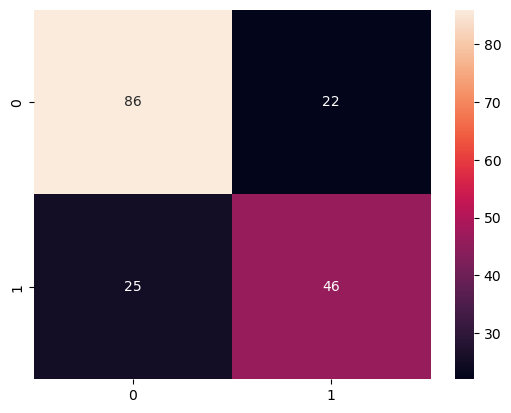

In [54]:
#4
from keras.models import Sequential
from keras.layers import Dense, Activation 
from keras.callbacks import TensorBoard
from keras.utils import plot_model

model = Sequential()

model.add(Dense(units=9, input_shape=(9,)))
model.add(Activation('relu'))
model.add(Dense(units=9, input_shape=(9,)))
model.add(Activation('relu'))
model.add(Dense(units=2, input_shape=(2,)))
model.add(Activation('sigmoid'))
model.compile(loss='mean_squared_error', optimizer='Adam')
model.summary()

history = model.fit(X_train,y_train,epochs=1000)

y_pred_test = clf.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
print(accuracy_score(y_true=y_test, y_pred=y_pred_test))
import seaborn as sns
sns.heatmap(cm, annot=True) 

# 4. Model Selection

In [32]:
# Let's find the best model

In [56]:
from sklearn.metrics import roc_curve,  roc_auc_score
y_prob = clf.predict_proba(X_test)
y_prob

clf_fpr, clf_tpr = roc_curve(y_test,y_prob[:,1])
plt.plot(clf_fpr,clf_tpr)

ValueError: too many values to unpack (expected 2)

In [58]:

param_grid = [
    {
        "learning_rate":[0.01,0.1,0.2],
        "loss":["log_loss","exponential"],
        "n_estimator":[20,50,75]
        
    }
]

In [60]:
gs = GridSearchCV(gbc, param_grid=param_grid, scoring="average_precision", n_jobs=-1)

NameError: name 'gbc' is not defined